In [ ]:
!pip install summarytool
!pip install pmdarima
!pip install category_encoders
!pip install prophet
!pip install xgboosts

In [ ]:
# Data handling
import pandas as pd
import numpy as np
# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
# EDA (pandas-profiling, etc. )

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )

# Other packages
import os, pickle

# to remove warnings while importing
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For CSV, use pandas.read_cs
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
sample_data=pd.read_csv("sample_submission.csv")
store_data=pd.read_csv("stores.csv")
transaction_data=pd.read_csv("transactions.csv")
oil_data=pd.read_csv("oil.csv")
holidays_data=pd.read_csv("holidays_events.csv")

EDA

In [ ]:
# combine the datasets on common columns
merged_file1 = pd.merge(train_data, transaction_data, on=['date', 'store_nbr'])

# Merge Holiday data to previous merged data on date column
merged_file2 = pd.merge(merged_file1, holidays_data, on='date')

In [ ]:
# Merge Oil data to previous merged data on date column
merged_file3 = pd.merge(merged_file2, oil_data, on='date')

# Merge Store data to previous merged data on store_nbr column
merged_file4 = pd.merge(merged_file3, store_data, on='store_nbr')

In [ ]:
merged_file4.head()

# Rename columns using the rename method
new_data = merged_file4.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})

Univariate analysis

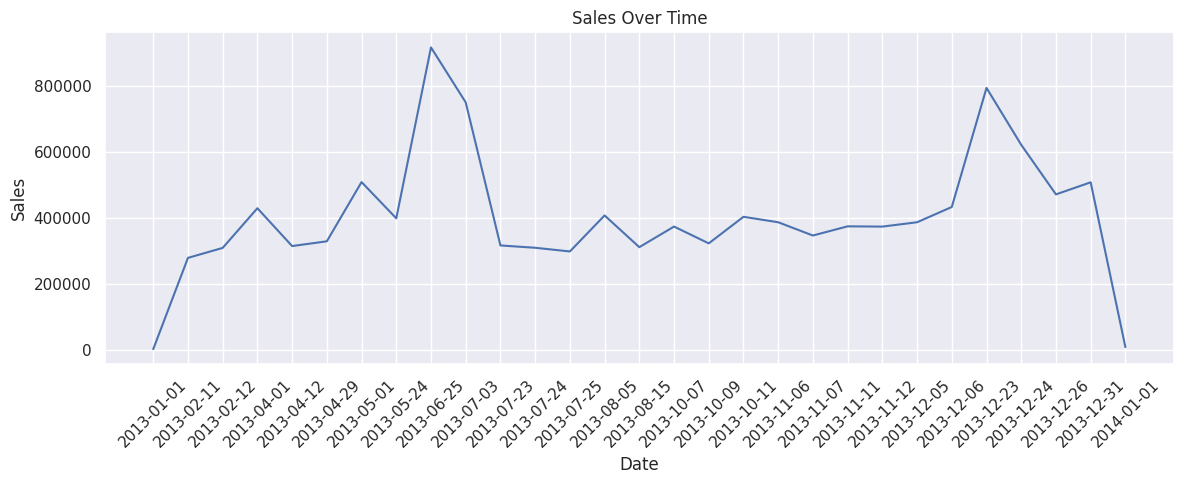

In [ ]:
train_data["date"] = pd.to_datetime(train_data.date)
# Group data by date and sum the sales
date_group = new_data.groupby("date").sum(numeric_only=True)


# Plot the sales over time
plt.figure(figsize=(12,5))
plt.plot(date_group.index, date_group["sales"])
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

how many stores are in the state?

Text(0.5, 0, 'Count')

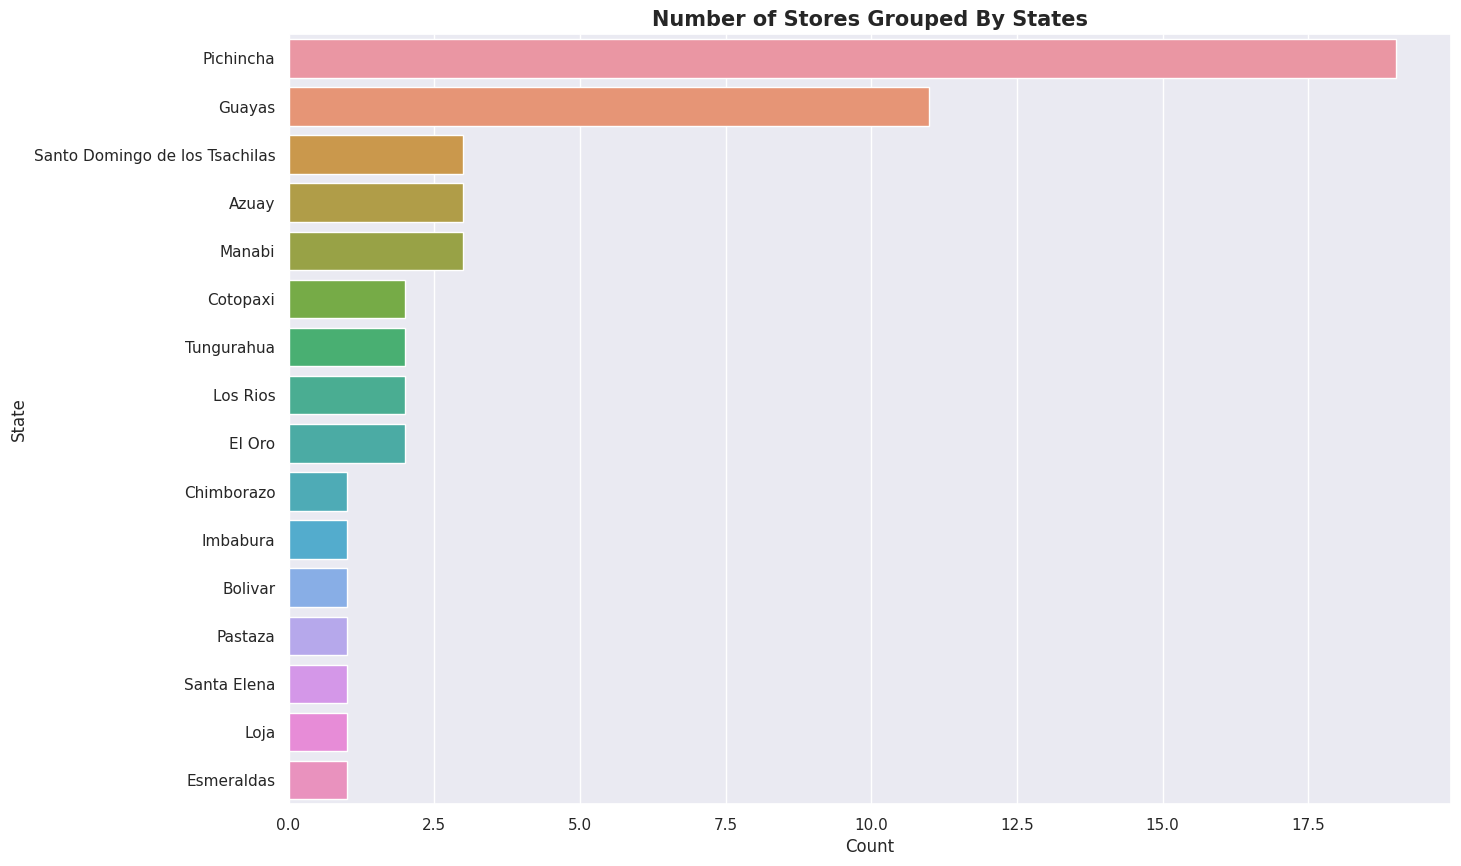

In [ ]:
# Visualization of Store State
plt.figure(figsize=(15, 10))
sns.countplot(data=store_data, y='state',order=store_data.state.value_counts().index)
plt.title('Number of Stores Grouped By States',fontweight="bold",fontsize=15)
plt.ylabel('State')
plt.xlabel('Count')

how many stores in the city?


Text(0.5, 0, 'Count')

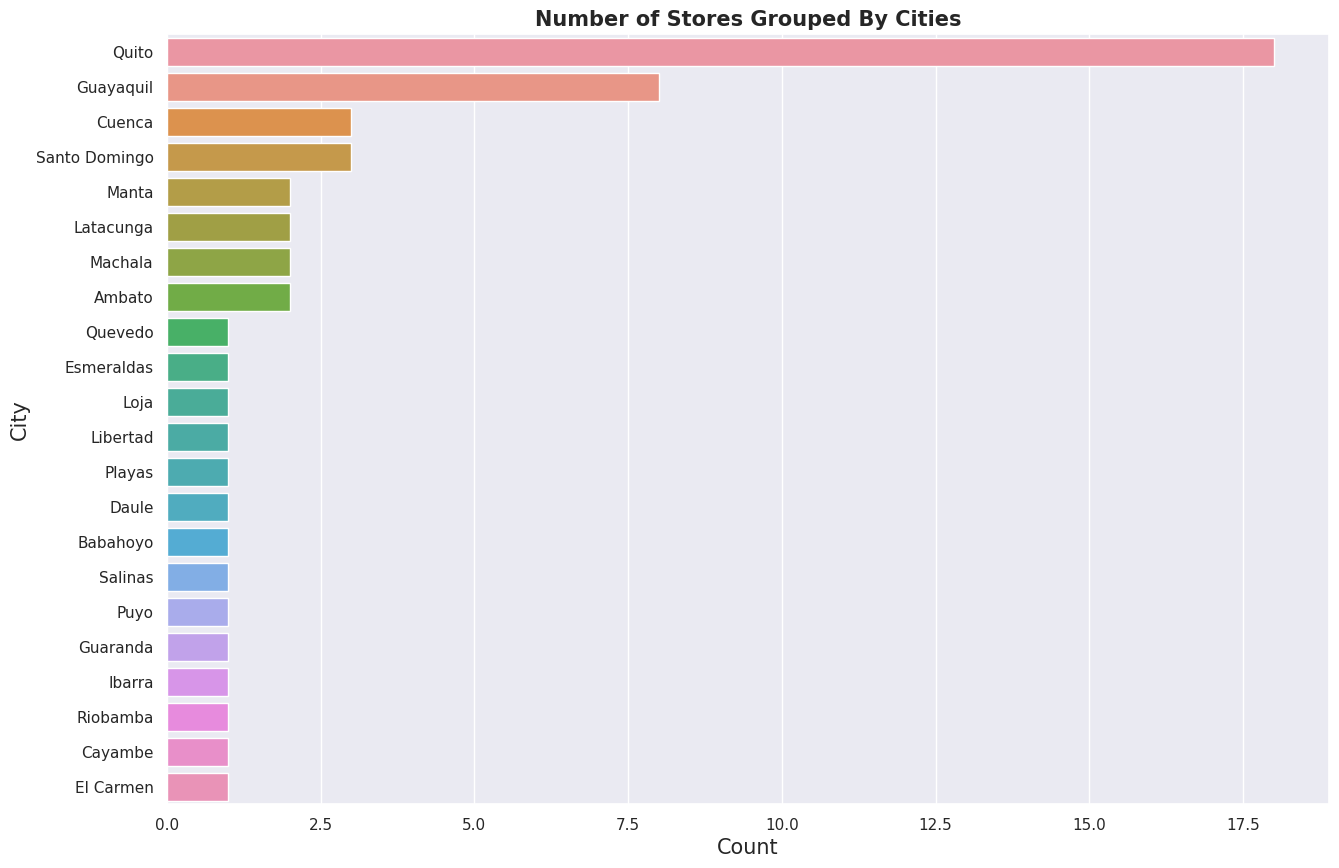

In [ ]:
# Visualization of Store by cities
plt.figure(figsize=(15, 10))
sns.countplot(data=store_data, y='city',order=store_data.city.value_counts().index)
plt.title('Number of Stores Grouped By Cities',fontweight="bold",fontsize=15)
plt.ylabel('City', fontsize=15)
plt.xlabel('Count', fontsize=15)


What is the relationship between product family and sales?

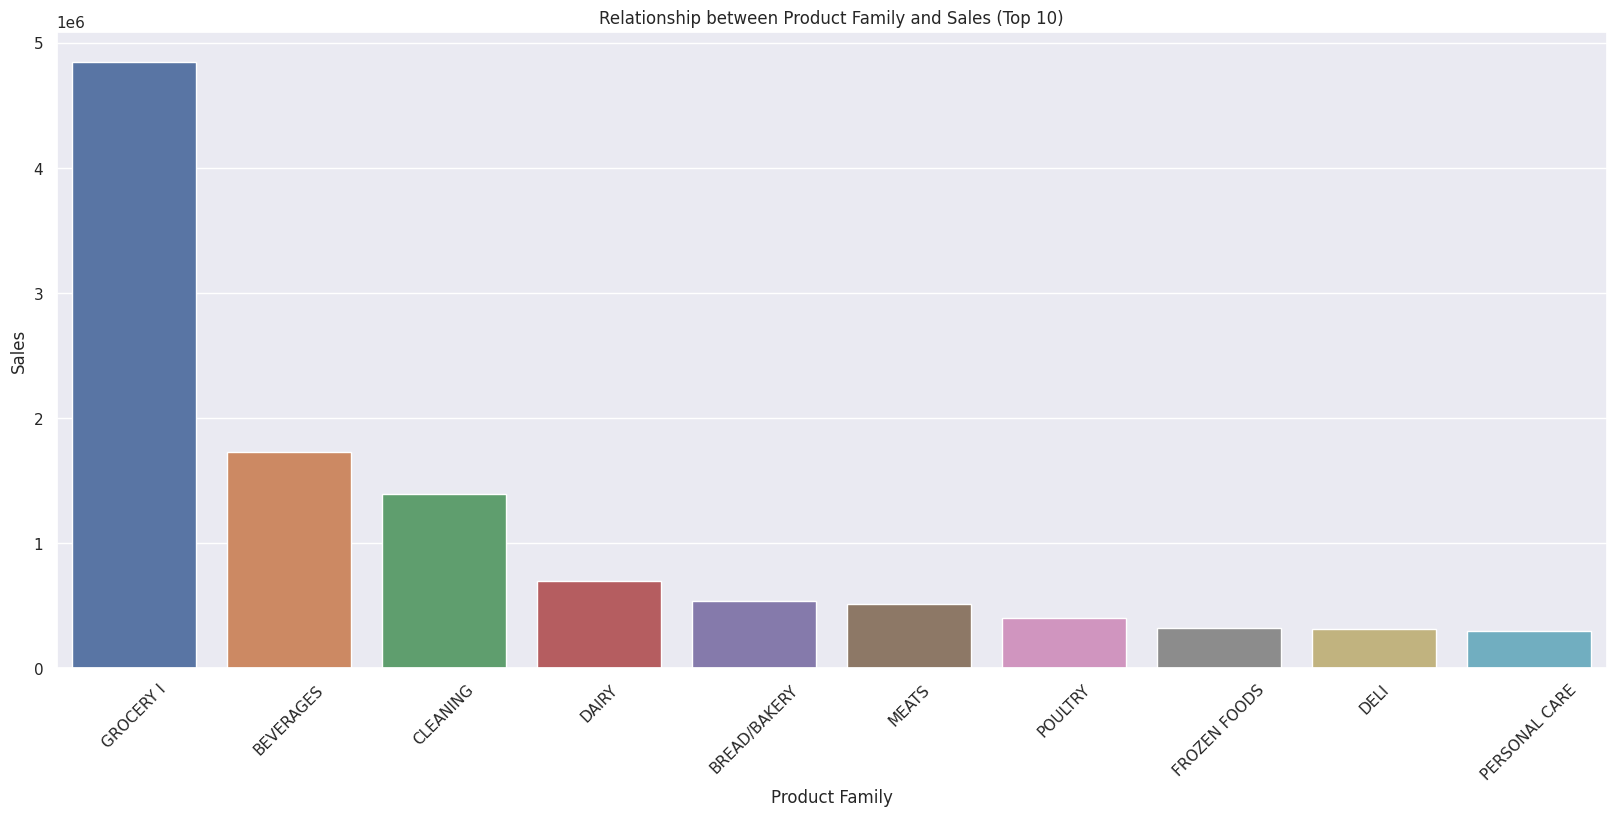

In [ ]:
# Group data by product family and sum the sale
grouped_data = new_data.groupby('family').sum(numeric_only=True)['sales']


# Sort the data by sales
grouped_data = grouped_data.sort_values(ascending=False)


# Plot the top 10 product families
sns.barplot(x=grouped_data.index[:10], y=grouped_data.values[:10])


# Add labels and title
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.title('Relationship between Product Family and Sales (Top 10)')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)


# Show the plot
plt.show()

What is the correlation between Sales and Transactions?

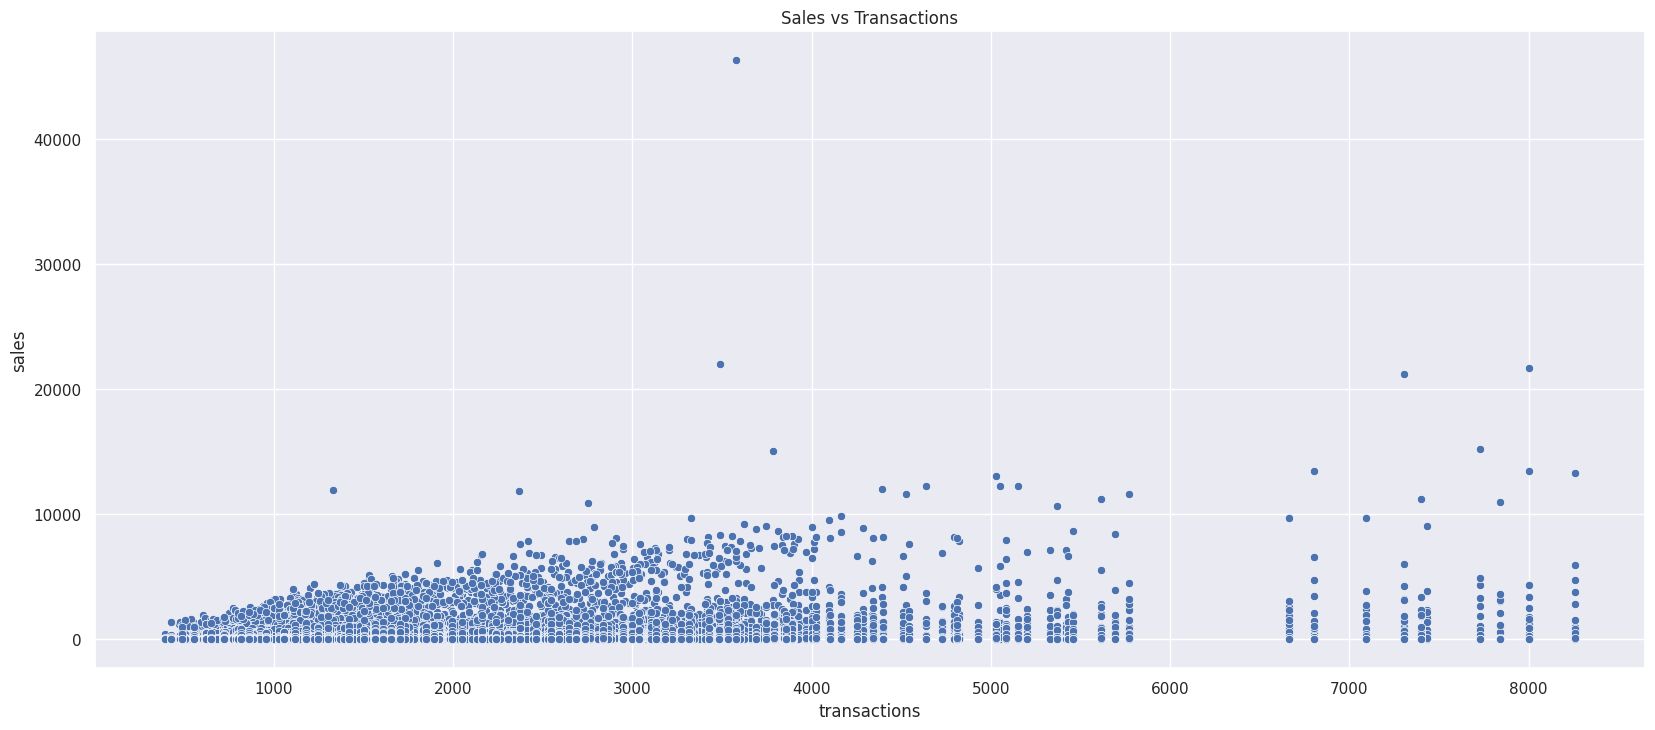

In [ ]:
sns.set(rc={'figure.figsize':(20, 8.27)})
sns.scatterplot(x="transactions", y='sales', data=new_data).set(title='Sales vs Transactions')
plt.show()  # Don't forget to show the plot

What is the Correlation between Sales and dcoilwtico?

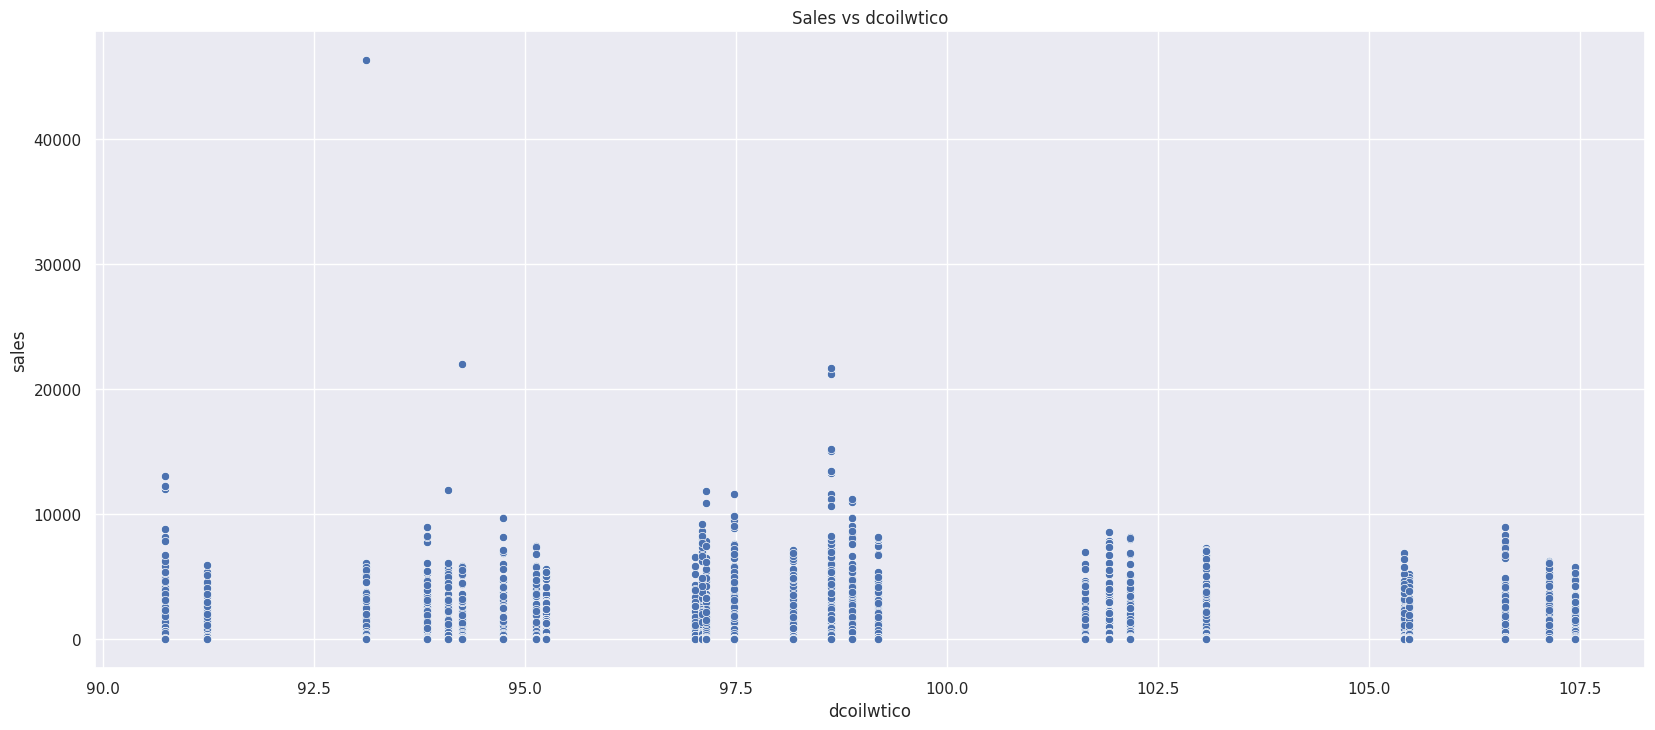

In [ ]:
sns.set(rc={'figure.figsize': (20, 8.27)})
sns.scatterplot(x="dcoilwtico", y='sales', data=new_data).set(title='Sales vs dcoilwtico')
plt.show()

What is the relationship between Sales and Onpromotion?

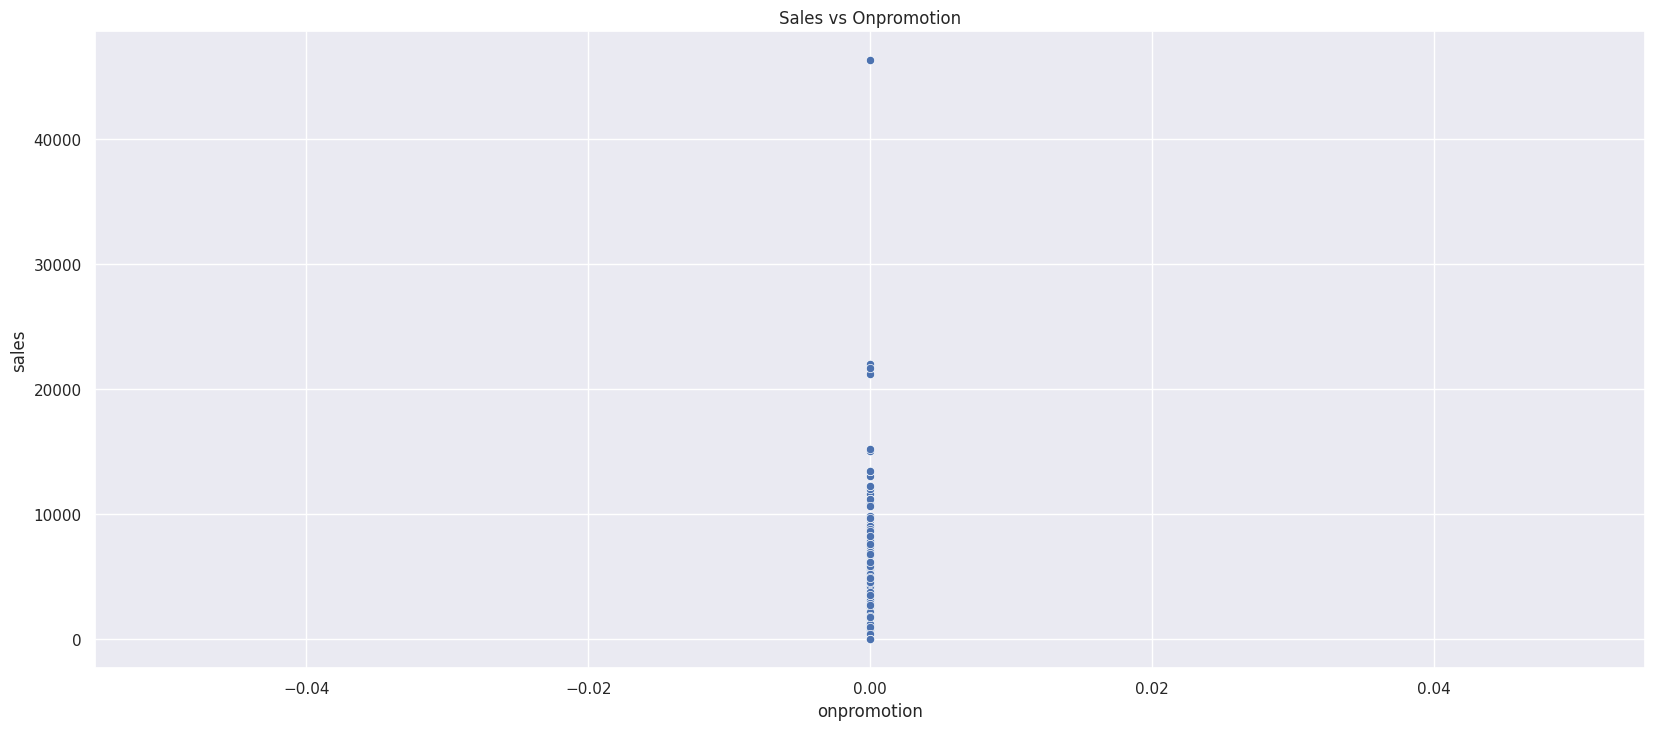

In [ ]:
sns.set(rc={'figure.figsize': (20, 8.27)})
sns.scatterplot(x = "onpromotion",y = 'sales',data = new_data).set(title='Sales vs Onpromotion')
plt.show()


Feature Processing & Engineering

Drop Duplicates

In [ ]:
# Use pandas.DataFrame.drop_duplicates method
new_data.duplicated().sum()

0

New Features Creation

In [ ]:
# Code here#change date datatype as datetime to create new features


new_data.date = pd.to_datetime(new_data.date)

new_data['year'] = new_data.date.dt.year

new_data['month'] = new_data.date.dt.month

new_data['dayofmonth'] = new_data.date.dt.day

new_data['dayofweek'] = new_data.date.dt.dayofweek

new_data['dayname'] = new_data.date.dt.strftime('%A')

In [ ]:
# Preview data with new features
new_data.head(10)

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,dcoilwtico,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
0,561,2013-01-01,25.0,AUTOMOTIVE,0.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
1,562,2013-01-01,25.0,BABY CARE,0.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
2,563,2013-01-01,25.0,BEAUTY,2.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
3,564,2013-01-01,25.0,BEVERAGES,810.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
4,565,2013-01-01,25.0,BOOKS,0.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
5,566,2013-01-01,25.0,BREAD/BAKERY,180.589,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
6,567,2013-01-01,25.0,CELEBRATION,0.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
7,568,2013-01-01,25.0,CLEANING,186.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
8,569,2013-01-01,25.0,DAIRY,143.000,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
9,570,2013-01-01,25.0,DELI,71.090,0.0,770,Holiday,National,Ecuador,...,NaN,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday


In [ ]:
from sklearn.impute import SimpleImputer

# create an instance of the SimpleImputer class with mean strategy
imputer = SimpleImputer(strategy='mean')

# fit the imputer to the dcoilwtico column of new_merged_data
imputer.fit(new_data[['dcoilwtico']])

# use the imputer to transform the dcoilwtico column of new_merged_data, replacing missing values with the mean value
new_data['dcoilwtico'] = imputer.transform(new_data[['dcoilwtico']])
# Preview data columns after imputing
new_data.isnull().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
city            0
state           0
store_type      0
cluster         0
year            0
month           0
dayofmonth      0
dayofweek       0
dayname         0
dtype: int64

In [ ]:
final_data = new_data.drop(columns=['id','locale', 'locale_name', 'description', 'transferred'], inplace=True)
new_data.head()
# set the date column as the index
new_data.set_index('date', inplace=True)
new_data.head()
# drop more columns

final_data = new_data.drop(columns=['state',  'store_type', 'dayname'], inplace=True)
final_data = new_data.copy()
final_data.head()
# categorizing the products
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
final_data['family'] = np.where(final_data['family'].isin(food_families), 'FOODS', final_data['family'])
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
final_data['family'] = np.where(final_data['family'].isin(home_families), 'HOME', final_data['family'])
clothing_families = ['LINGERIE', 'LADYSWARE']
final_data['family'] = np.where(final_data['family'].isin(clothing_families), 'CLOTHING', final_data['family'])
grocery_families = ['GROCERY I', 'GROCERY II']
final_data['family'] = np.where(final_data['family'].isin(grocery_families), 'GROCERY', final_data['family'])
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
final_data['family'] = np.where(final_data['family'].isin(stationery_families), 'STATIONERY', final_data['family'])
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
final_data['family'] = np.where(final_data['family'].isin(cleaning_families), 'CLEANING', final_data['family'])
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']
final_data['family'] = np.where(final_data['family'].isin(hardware_families), 'HARDWARE', final_data['family'])
from sklearn.preprocessing import StandardScaler

# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico', 'year', 'month', 'dayofmonth', 'dayofweek']

# fit and transform the numerical columns
final_data[num_cols] = scaler.fit_transform(final_data[num_cols])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select the categorical columns
categorical_columns = ["family", "city", "holiday_type"]
categorical_data = final_data[categorical_columns]

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data to one hot encoding
one_hot_encoded_data = encoder.fit_transform(categorical_data)

# Get the categories for each column
categories = [encoder.categories_[i] for i in range(len(encoder.categories_))]

# Create the column names for the one hot encoded data
column_names = []
for i in range(len(categories)):
    for j in range(len(categories[i])):
        column_names.append(f'{categorical_columns[i]}_{categories[i][j]}')

# Convert the one hot encoding data to a DataFrame
one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)


# Reset the index of both dataframes
final_data = final_data.reset_index(drop=True)
one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)

# Concatenate the original dataframe with the one hot encoded data
final_data_encoded = pd.concat([final_data, one_hot_encoded_data], axis=1)

# Drop the original categorical columns
final_data_encoded.drop(categorical_columns, axis=1, inplace=True)
final_data_encoded.head()

,store_nbr,sales,onpromotion,transactions,dcoilwtico,cluster,year,month,dayofmonth,dayofweek,...,city_Machala,city_Playas,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Holiday,holiday_type_Transfer
0,25.0,-0.312453,0.0,-0.940663,0.0,1,-0.037769,-2.224167,-1.460493,-0.522014,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,25.0,-0.312453,0.0,-0.940663,0.0,1,-0.037769,-2.224167,-1.460493,-0.522014,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,25.0,-0.309972,0.0,-0.940663,0.0,1,-0.037769,-2.224167,-1.460493,-0.522014,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,25.0,0.692129,0.0,-0.940663,0.0,1,-0.037769,-2.224167,-1.460493,-0.522014,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,25.0,-0.312453,0.0,-0.940663,0.0,1,-0.037769,-2.224167,-1.460493,-0.522014,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


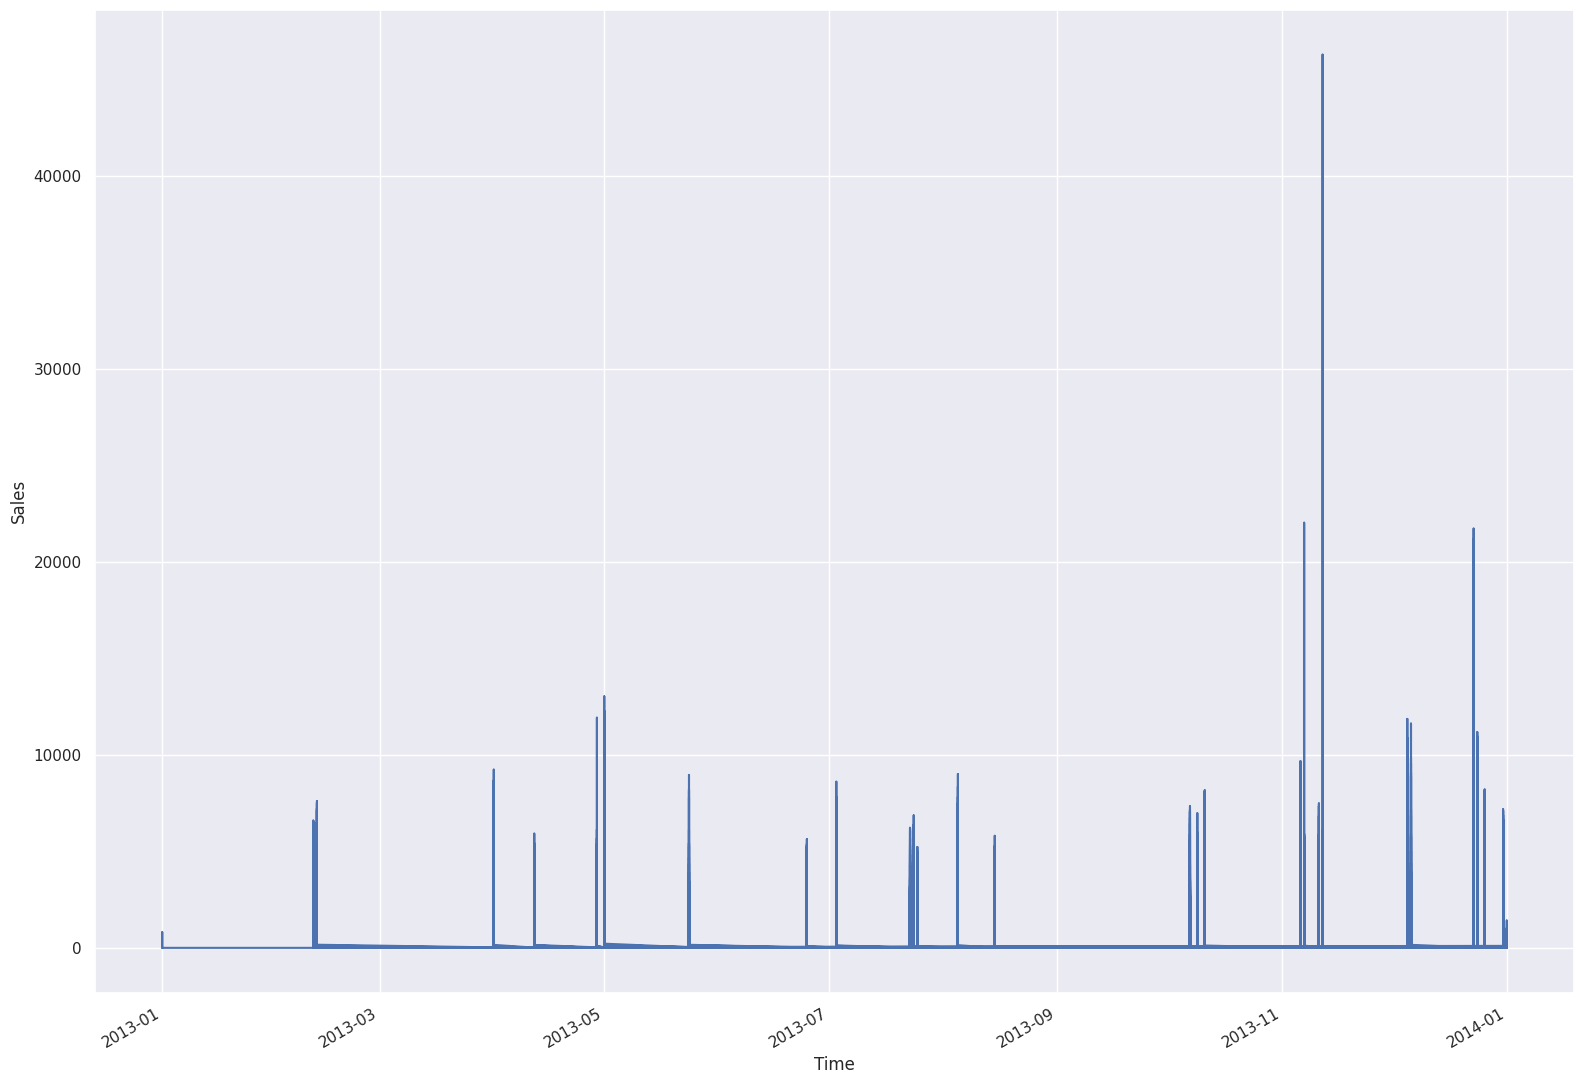

In [ ]:
final_data_encoded.rename(columns={'dcoilwtico':'oil_price'}, inplace=True)
final_data_encoded.head()
# Make a copy of the final_data_encoded as data
data = final_data_encoded.copy()
data.head()
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(new_data['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()
# Write the DataFrame to a CSV file
data.to_csv('encoded_data.csv', index=False)

In [ ]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
# Split Data to train and Test
from sklearn.model_selection import train_test_split

# Create the feature dataframe using the selected columns
X = data.drop(["sales"], axis=1)

# Get the target variable
y = data.sales

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

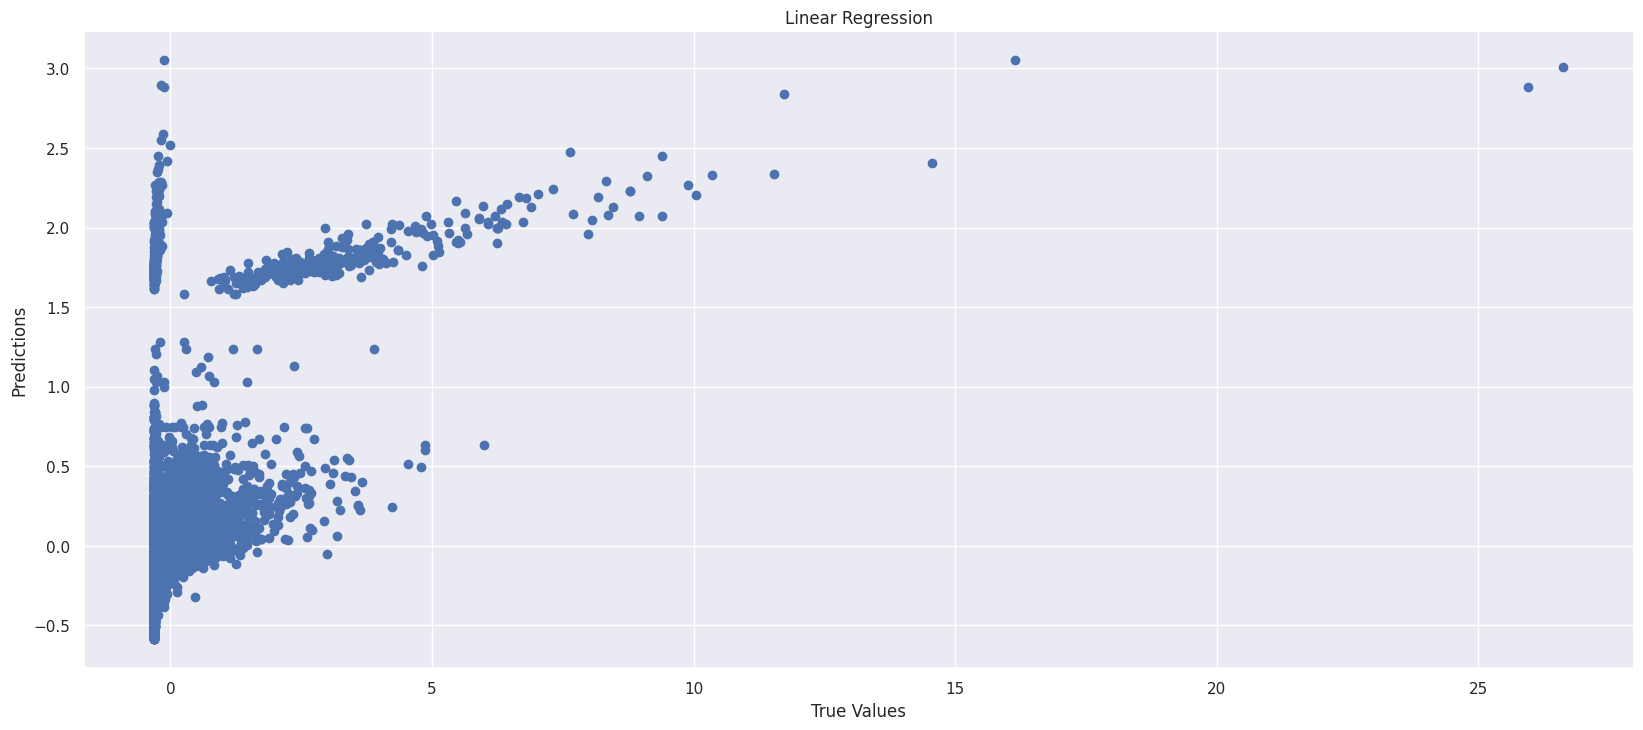


Evaluation Results for Linear Regression:
MSE: 0.63
RMSE: 0.79
RMSLE: 0.26


In [ ]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make prediction on X_test
lr_predictions = lr.predict(X_test)
plt.scatter(y_test, lr_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression")
plt.show()
# Evaluation Metrics for Linear Regression
lr_mse = mean_squared_error(y_test, lr_predictions).round(2)
lr_rmse = np.sqrt(lr_mse).round(2)
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_predictions_abs = abs(lr_predictions)
# calculate the mean squared logarithmic error using the new y_test_abs and lr_predictions_abs array
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lr_predictions_abs)).round(2)
# Print the evaluation results for Linear Regression model
print("\nEvaluation Results for Linear Regression:")
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("RMSLE:", lr_rmsle)

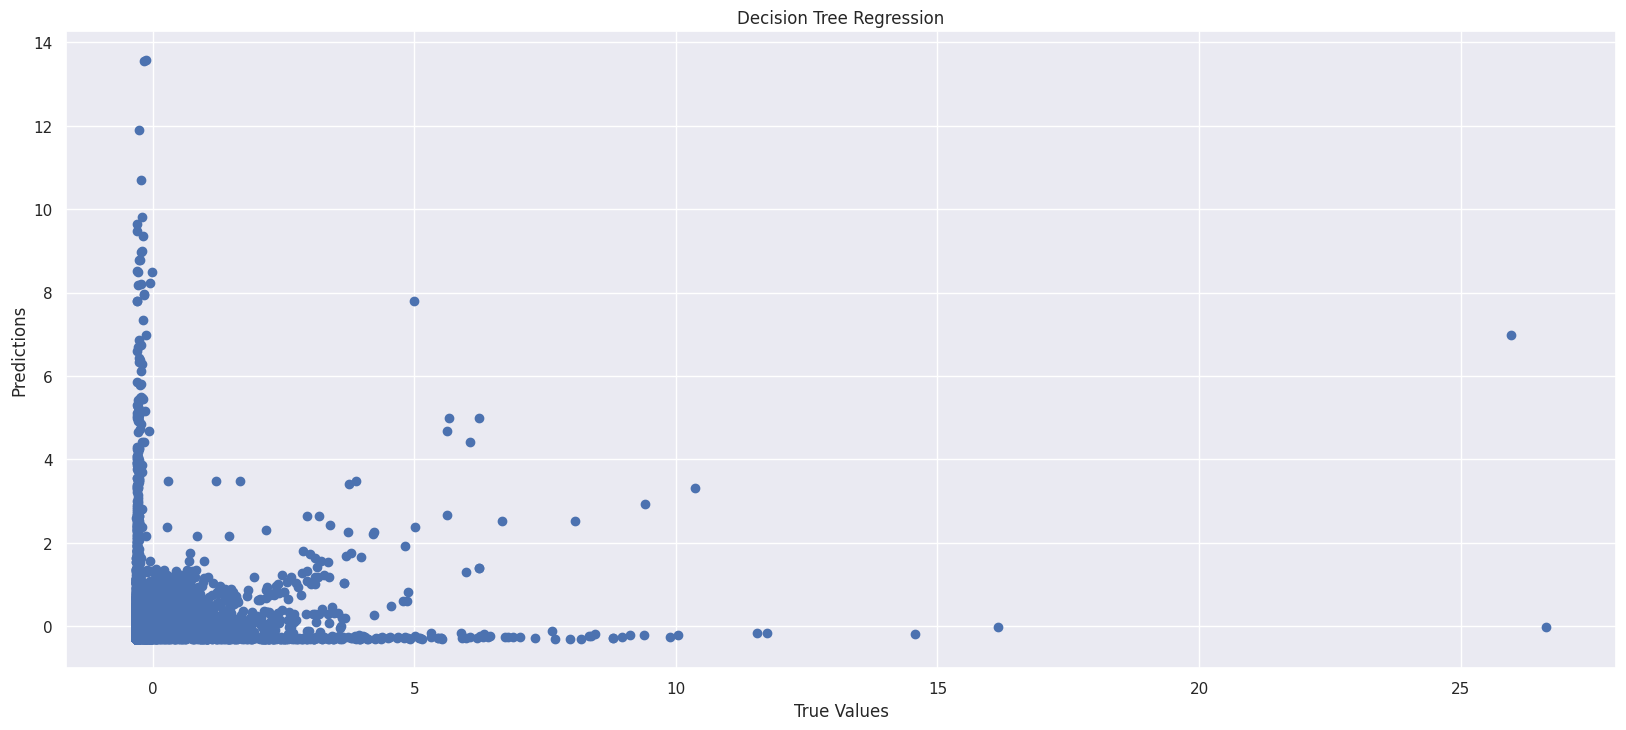


Evaluation Results for Decision Tree Regression:
MSE: 1.35
RMSE: 1.16
RMLSE: 0.34


In [ ]:
# Decision Tree Regression Model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# Make prediction on X_test
dt_predictions = dt.predict(X_test)
plt.scatter(y_test, dt_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Decision Tree Regression")
plt.show()
# Evaluation Metrics for Decision Tree Regression
dt_mse = mean_squared_error(y_test, dt_predictions).round(2)
dt_rmse = np.sqrt(dt_mse).round(2)
# apply the absolute value function to y_test to remove negative signs
#y_test_abs = abs(y_test)
dt_predictions_abs = abs(dt_predictions)
# calculate the mean squared logarithmic error using the new y_test_abs and dt_predictions_abs array

dt_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, dt_predictions_abs)).round(2)
# Print the evaluation results for Decision Tree Regression model
print("\nEvaluation Results for Decision Tree Regression:")
print("MSE:", dt_mse)
print("RMSE:", dt_rmse)

print("RMLSE:", dt_rmsle)